# <center> Aplicación en Bioestadística: Análisis de Depresión en RR.SS.
## <center>Saturday's AI Euskadi 2020

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations
from regresion_functions import printHistograms

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Read the raw data and display first rows

data = pd.read_csv('../raw-data/OSF_socialmedia_data.csv', index_col=0)
data.head()

,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,Session.Instance,...,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,AutoPSMU,News,Active
1,115091,05/02/2017,Tuesday,10:00:06,Daily questions,1,1,1,1,1.0,...,61.0,64.0,68.0,50.0,56.0,73.0,66.0,66,39.0,38.0
2,115091,05/02/2017,Tuesday,12:02:48,Daily questions,2,1,1,1,2.0,...,57.0,70.0,58.0,37.0,56.0,67.0,0.0,#skipped#,27.0,23.0
3,115091,05/02/2017,Tuesday,14:03:02,Daily questions,3,1,1,1,3.0,...,44.0,70.0,67.0,26.0,38.0,39.0,63.0,56,34.0,36.0
4,115091,05/02/2017,Tuesday,16:34:28,Daily questions,4,1,1,1,4.0,...,56.0,79.0,89.0,30.0,20.0,60.0,67.0,68,29.0,23.0
5,115091,05/02/2017,Tuesday,18:00:00,Daily questions,5,1,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Show how many observations (rows), variables (columns), and participants we have

print(f"There are {data.shape[0]:,} observations (rows) in the dataframe.")
print(f"There are {data.shape[1]:,} variables (columns) in the dataframe.")
print(f"There are {data['Participant'].unique().size} individual participants in the study.")

There are 12,245 observations (rows) in the dataframe.
There are 25 variables (columns) in the dataframe.
There are 125 individual participants in the study.


In [4]:
# Show basic information from the dataframe

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12245 entries, 1 to 12245
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Participant                      12245 non-null  int64  
 1   Date                             12245 non-null  object 
 2   Day                              12245 non-null  object 
 3   Time                             12245 non-null  object 
 4   Session.Name                     12245 non-null  object 
 5   Notification.No                  12245 non-null  int64  
 6   LifePak.Download.No              12245 non-null  int64  
 7   Responded                        12245 non-null  int64  
 8   Completed.Session                12245 non-null  int64  
 9   Session.Instance                 8695 non-null   float64
 10  Session.Instance.Response.Lapse  8695 non-null   object 
 11  Reminders.Delivered              12245 non-null  int64  
 12  Instr_DQs         

## Data wrangling

- [x] Change data format to *Date* column
- [x] Rename *Active* and *DeprMood* variables
- [x] Drop the *AutoPSMU* and *Instr_DQs* variables
- [x] Delete invalid observations
- [x] Delete observations with only null responses to out variables of interest


In [5]:
# Converted the Date column to datetime format

data['Date']= pd.to_datetime(data['Date'])
data.head()

,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,Session.Instance,...,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,AutoPSMU,News,Active
1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,1.0,...,61.0,64.0,68.0,50.0,56.0,73.0,66.0,66,39.0,38.0
2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,2.0,...,57.0,70.0,58.0,37.0,56.0,67.0,0.0,#skipped#,27.0,23.0
3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,3.0,...,44.0,70.0,67.0,26.0,38.0,39.0,63.0,56,34.0,36.0
4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,4.0,...,56.0,79.0,89.0,30.0,20.0,60.0,67.0,68,29.0,23.0
5,115091,2017-05-02,Tuesday,18:00:00,Daily questions,5,1,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The *Active* variable refers to the active use of social media, so we are going to rename it *ASMU* (active social media use) to match the PSMU variable naming convention. The *DeprMood* refers to a low mood, so we are goint to rename it *LowMood* to avoid confusion between the concepts of depression and depressed or low mood.

In [6]:
# Rename the Active and DeprMood variables

data = data.rename(columns={'Active':'ASMU'})
data = data.rename(columns={'DeprMood':'LowMood'})

We selected those columns that belong to the ESM questionnaire (Experience Sampling Methodology) of depressive symptoms and explore how they are distributed.

The publication where this data comess from explains that the *AutoPSMU* column refers to the automatic and passive use of social media. However, many of the participants did not respond to this section. The researchers did not take it into account and so shall we. We also removed the *Instr_DQs* column as it only has null values.

In [7]:
# Drop the AutoPSMU and Instr_DQs variables

data.drop('AutoPSMU', axis=1, inplace=True)
data.drop('Instr_DQs', axis=1, inplace=True)
data.head()

,Participant,Date,Day,Time,Session.Name,Notification.No,LifePak.Download.No,Responded,Completed.Session,Session.Instance,...,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,News,ASMU
1,115091,2017-05-02,Tuesday,10:00:06,Daily questions,1,1,1,1,1.0,...,55.0,61.0,64.0,68.0,50.0,56.0,73.0,66.0,39.0,38.0
2,115091,2017-05-02,Tuesday,12:02:48,Daily questions,2,1,1,1,2.0,...,59.0,57.0,70.0,58.0,37.0,56.0,67.0,0.0,27.0,23.0
3,115091,2017-05-02,Tuesday,14:03:02,Daily questions,3,1,1,1,3.0,...,20.0,44.0,70.0,67.0,26.0,38.0,39.0,63.0,34.0,36.0
4,115091,2017-05-02,Tuesday,16:34:28,Daily questions,4,1,1,1,4.0,...,25.0,56.0,79.0,89.0,30.0,20.0,60.0,67.0,29.0,23.0
5,115091,2017-05-02,Tuesday,18:00:00,Daily questions,5,1,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We deleted those measurements that were considered invalid by the original authors of the publication.

In [8]:
# Keep only those observations (rows) with a 1 response in the Responded variable

data = data[(data['Responded'] == 1)]
print(f"There are {data.shape[0]:,} observations (rows) left in the dataframe.")

There are 8,695 observations (rows) left in the dataframe.


We deleted those measurements that, even though they were considered *valid*, have null values for all variables of interest. We added a new column with the number of null values that each observation had in our variables of interest.

In [9]:
# Create a new column with null value counts across variables of interest

data['full_count'] = data.apply(lambda x: x.count()-13, axis=1)
full_count_values = data['full_count'].value_counts().sort_index()

In [10]:
# Drop those observations (rows) with only 0 responses across variables

data = data.drop(data[data.full_count == 0].index)
print(f"There are {data.shape[0]:,} observations (rows) left in the dataframe.")

There are 8,687 observations (rows) left in the dataframe.


Now our dataframe is ready for the exploratory data analysis and modelling phases. We will save a copy of the tidy dataframe to avoid messing with the raw data.

In [11]:
# Save the tidy data frame

data.to_csv('../processed-data/tidy_socialmedia_data.csv')

## Exploratory Data Analysis

- Explore the distribution of the ESM questionnaire variables
- Explore the distribution of the social media use variables
- Explore the overall time structure of the data
- Explore distribution changes over time for each variable of interest

In [12]:
# Select ESM questionnaire variables

ESM_quest = data.loc[:,['Fatigue', 'LowMood', 'Loneliness',
                        'Concentrat', 'LossOfInt', 'Inferior',
                        'Hopeless', 'Stress']]

ESM_quest.describe().round()

,Fatigue,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress
count,8652.0,8647.0,8646.0,8643.0,8646.0,8646.0,8649.0,8648.0
mean,37.0,13.0,12.0,26.0,26.0,11.0,12.0,21.0
std,30.0,18.0,17.0,26.0,26.0,15.0,17.0,23.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,10.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
50%,30.0,6.0,5.0,19.0,18.0,3.0,5.0,14.0
75%,64.0,20.0,18.0,45.0,40.0,17.0,19.0,30.0
max,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [13]:
print(f"There are {ESM_quest.shape[0]:,} observations (rows) plotted below.")

There are 8,687 observations (rows) plotted below.


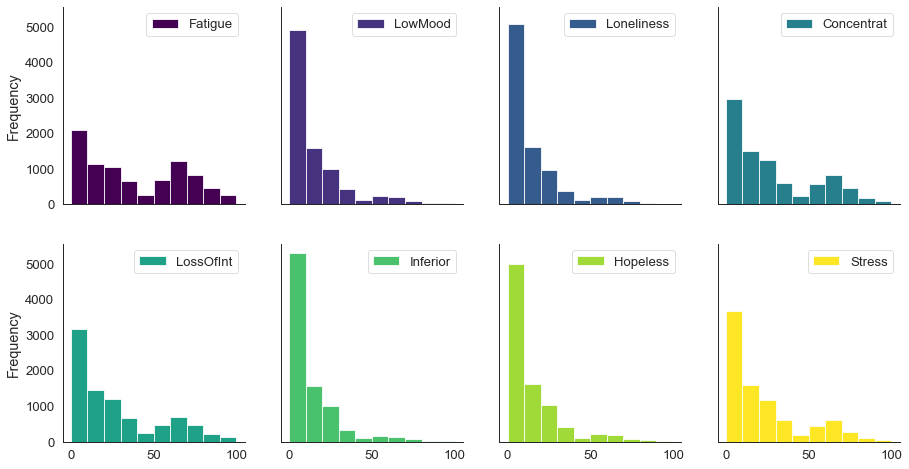

In [14]:
# Plot ESM questionnaire variables

printHistograms(ESM_quest, 'viridis')
plt.savefig('../figures/ESM_quest-hist.png')

In [15]:
dailyMean = data.groupby(["Participant", "Date"], as_index=False)[['Fatigue', 'LowMood', 'Loneliness', 'Concentrat', 'LossOfInt', 'Inferior', 'Hopeless', 'Stress']].mean()
dailyMean

,Participant,Date,Fatigue,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress
0,115091,2017-05-02,41.666667,33.000000,36.333333,59.000000,72.833333,30.500000,31.666667,52.666667
1,115091,2017-05-03,63.166667,22.666667,21.000000,56.000000,56.166667,11.333333,18.333333,36.333333
2,115091,2017-05-04,78.333333,28.833333,34.500000,66.833333,73.333333,24.333333,28.500000,59.833333
3,115091,2017-05-05,27.333333,16.500000,16.833333,25.333333,44.500000,24.333333,18.166667,30.833333
4,115091,2017-05-06,67.200000,32.200000,33.600000,37.000000,46.000000,39.000000,18.000000,49.400000
...,...,...,...,...,...,...,...,...,...,...
1722,9873359,2017-04-21,7.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1723,9873359,2017-04-22,22.428571,2.714286,1.142857,0.000000,5.571429,0.000000,0.000000,5.571429
1724,9873359,2017-04-23,26.666667,1.833333,5.000000,0.166667,8.000000,0.000000,1.833333,1.000000
1725,9873359,2017-04-24,9.000000,1.666667,3.000000,10.666667,2.333333,1.666667,2.166667,1.166667


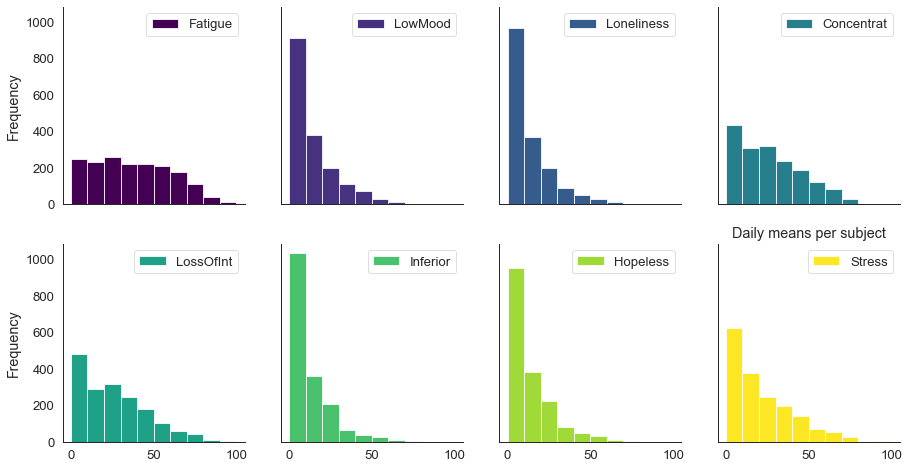

In [18]:
# Plot daily means of ESM questionnaire variables per subject

dailyMean_ESM_quest = dailyMean.loc[:,['Fatigue', 'LowMood', 'Loneliness',
                        'Concentrat', 'LossOfInt', 'Inferior',
                        'Hopeless', 'Stress']]
printHistograms(dailyMean_ESM_quest, 'viridis')
plt.savefig('../figures/dailyMean_ESM_quest-hist.png')

In [19]:
participantMean = data.groupby(["Participant"], as_index=False)[['Fatigue', 'LowMood', 'Loneliness', 'Concentrat', 'LossOfInt', 'Inferior', 'Hopeless', 'Stress']].mean()
participantMean

,Participant,Fatigue,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress
0,115091,45.155844,20.454545,23.285714,37.272727,47.675325,17.831169,21.389610,37.441558
1,131183,36.288136,3.474576,0.389831,19.508475,14.508475,0.254237,0.406780,16.898305
2,438907,51.040816,26.285714,21.833333,35.729167,50.979592,23.395833,14.591837,25.000000
3,515070,34.865385,12.692308,14.076923,32.903846,16.038462,11.403846,10.500000,17.365385
4,572172,18.272727,10.738636,9.375000,14.352273,25.761364,38.056818,17.431818,20.511364
...,...,...,...,...,...,...,...,...,...
120,9585150,58.018519,7.592593,0.500000,6.962963,22.000000,0.018519,0.240741,3.722222
121,9593823,32.397059,17.588235,14.955882,23.298507,17.544118,8.397059,13.044776,23.164179
122,9813325,18.967213,10.081967,7.836066,8.049180,10.180328,7.852459,6.950820,9.688525
123,9873128,22.967033,8.439560,8.747253,12.439560,12.466667,7.923077,7.791209,8.222222


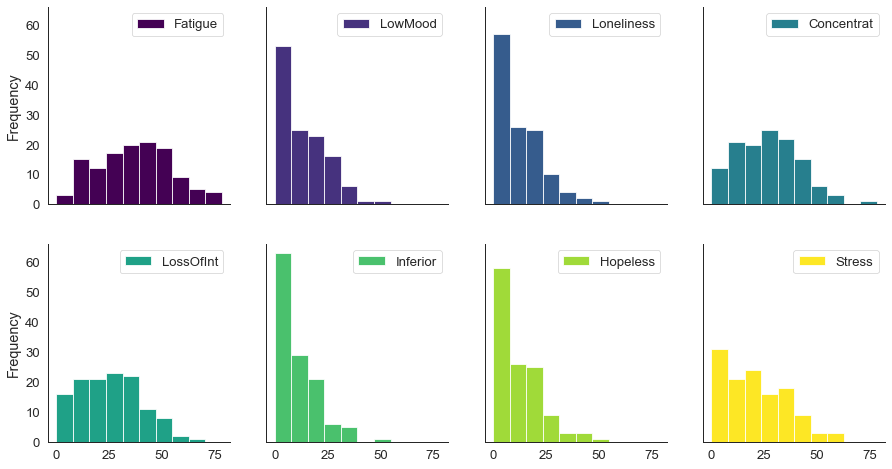

In [20]:
# Plot daily means of ESM questionnaire variables per subject

participantMean_ESM_quest = participantMean.loc[:,['Fatigue', 'LowMood', 'Loneliness',
                        'Concentrat', 'LossOfInt', 'Inferior',
                        'Hopeless', 'Stress']]
printHistograms(participantMean_ESM_quest, 'viridis')
plt.savefig('../figures/participantMean_ESM_quest-hist.png')

In [21]:
# Select social media use variables

SMU_quest = data.loc[:,['PSMU', 'ASMU', 'News']]
SMU_quest.describe().round()

,PSMU,ASMU,News
count,8644.0,8645.0,8647.0
mean,32.0,21.0,21.0
std,29.0,25.0,25.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,24.0,12.0,12.0
75%,61.0,33.0,31.0
max,100.0,100.0,100.0


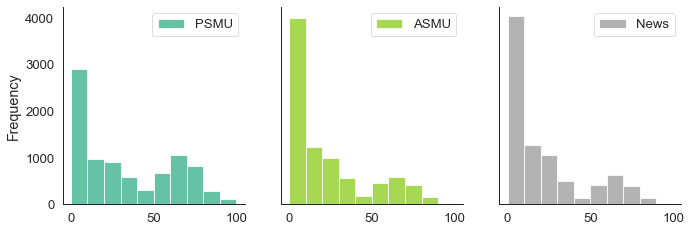

In [22]:
# Plot social media use variables

printHistograms(SMU_quest, 'Set2')
plt.savefig('../figures/SMU_quest-hist.png')

It might be interesting to group subjects according to when they started and finished the experiment, so that we can see whether there are groups with overlapping time series.

In [23]:
# Create a new array with the start and end dates of each participant

dates = pd.DataFrame([])

for participant in data.Participant.unique():
    dates = dates.append(pd.DataFrame({
            'start': data[data.Participant==participant].Date.min(),
            'end': data[data.Participant==participant].Date.max()},
            index=[0]), ignore_index=True)

dates.head()

,start,end
0,2017-05-02,2017-05-15
1,2017-05-11,2017-05-24
2,2017-04-06,2017-04-19
3,2017-04-07,2017-04-20
4,2017-04-12,2017-04-25


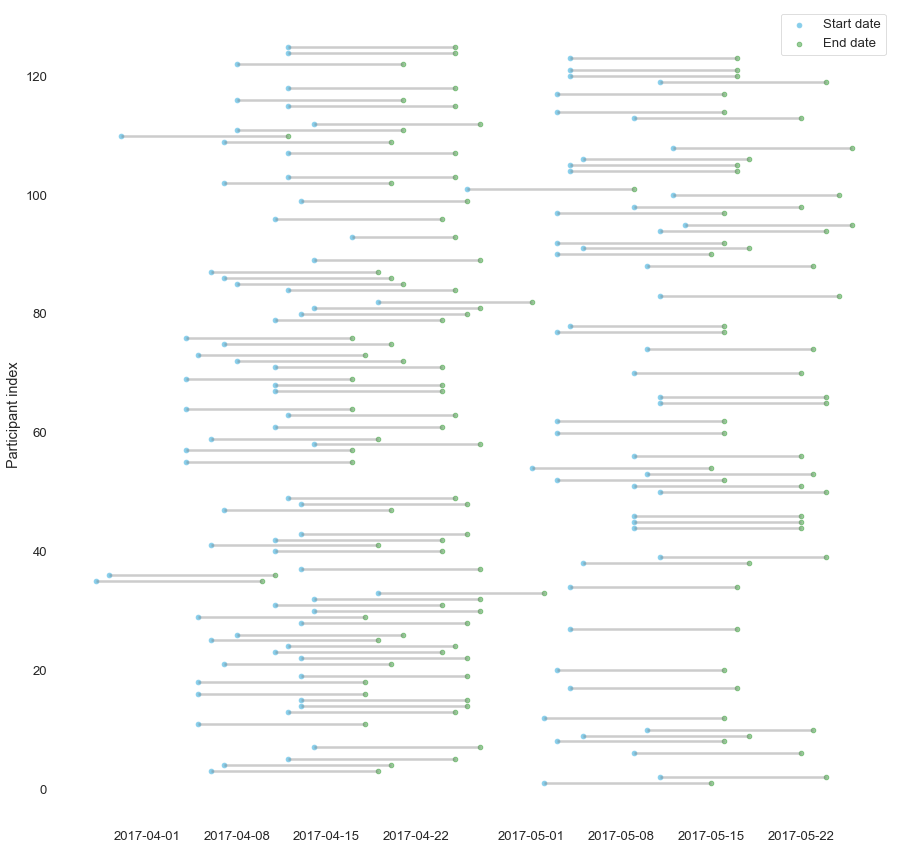

In [24]:
# Plot start and end dates joint by a line for each participant

my_range=range(1,len(dates.index)+1)

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig = plt.figure(figsize=(15, 15))

plt.hlines(y=my_range, xmin=dates.start, xmax=dates.end, color='grey', alpha=0.4)
plt.scatter(dates.start, my_range, color='skyblue', alpha=1, label='Start date')
plt.scatter(dates.end, my_range, color='green', alpha=0.4 , label='End date')

plt.ylabel('Participant index')
plt.legend()
sns.despine(left=True, bottom=True, trim=True)
plt.savefig('../figures/exp_duration-unord-lollipop.png')

Instead of sorting data by participant index, we better do it by start date to explore possible date overlaps.

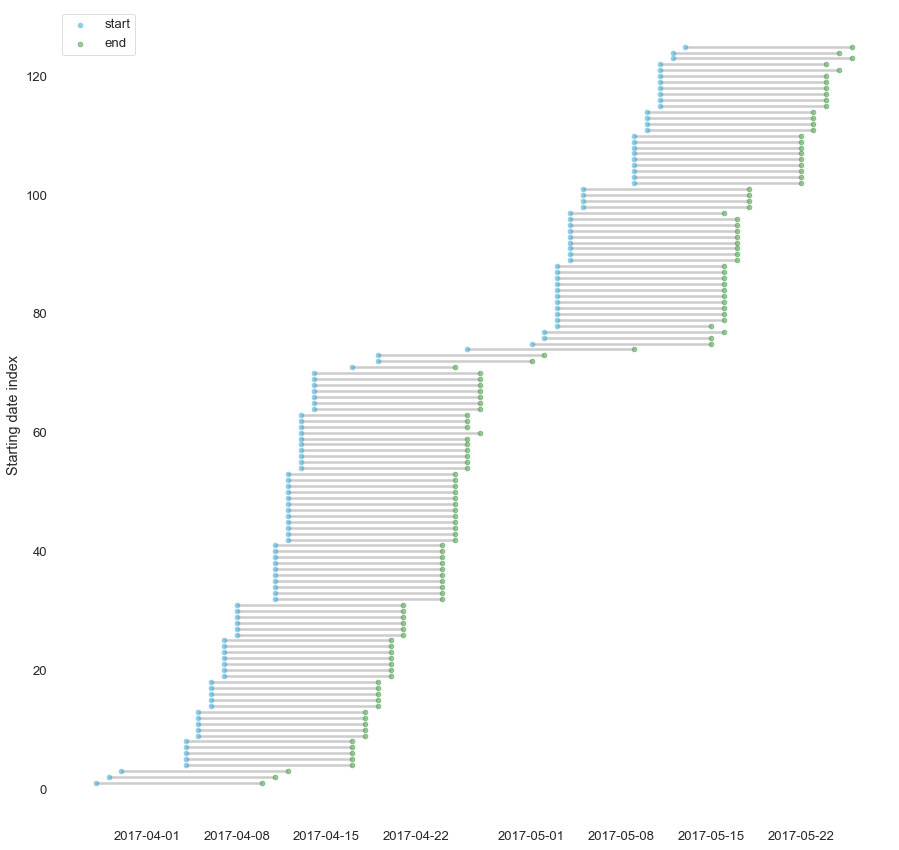

In [25]:
# Plot ordered start and end dates joint by a line for each participant

ordered_dates = dates.sort_values(by=['start'])

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig = plt.figure(figsize=(15, 15))

plt.hlines(y=my_range, xmin=ordered_dates.start, xmax=ordered_dates.end, color='grey', alpha=0.4)
plt.scatter(ordered_dates.start, my_range, color='skyblue', alpha=1, label='start')
plt.scatter(ordered_dates.end, my_range, color='green', alpha=0.4 , label='end')

plt.ylabel('Starting date index')
plt.legend()
sns.despine(left=True, bottom=True, trim=True)
plt.savefig('../figures/exp_duration-ord-lollipop.png')

Did depresssion-related symptoms change over time during the experiment?

In [30]:
fields = ['Fatigue', 'LowMood', 'Loneliness', 'Concentrat', 'LossOfInt', 'Inferior', 'Hopeless', 'Stress', 'PSMU', 'News', 'ASMU']
df_test = pd.DataFrame(columns=fields)
index = 0

test_df = pd.DataFrame()
for day in data.Day.unique():
    for field in fields:
        df_test.insert(index, field, data.groupby(["Day"])[field].mean(), True)
        index += 1

dailyMeans = df_test.iloc[:,:11]

In [31]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dailyMeans = dailyMeans.loc[day_order]
display(dailyMeans)

,Fatigue,LowMood,Loneliness,Concentrat,LossOfInt,Inferior,Hopeless,Stress,PSMU,News,ASMU
Day,,,,,,,,,,,
Monday,36.924159,12.629601,11.849530,26.730829,26.284597,10.045383,11.810642,20.127543,31.351330,20.127543,20.938967
Tuesday,37.901090,14.028816,13.007788,28.777259,26.899533,11.042835,12.504673,21.544393,34.468847,21.568536,22.154206
Wednesday,35.921260,13.044094,11.908589,28.341483,25.293932,10.759464,12.523997,21.903861,33.434543,22.388013,23.830709
Thursday,36.904288,13.317485,12.235249,27.990031,24.122699,10.618098,12.099617,21.694253,32.003067,20.737931,22.977795
Friday,37.550336,13.229866,12.096396,26.039496,25.450882,10.803018,12.696309,20.811083,29.777498,20.538139,20.951261
Saturday,36.836094,12.803836,11.691972,23.192845,25.243455,10.600349,11.515707,19.271142,28.339442,19.376091,18.413613
Sunday,36.877342,12.947144,10.887468,22.994885,25.179028,10.201194,10.911338,18.833049,31.367434,20.736573,20.137489


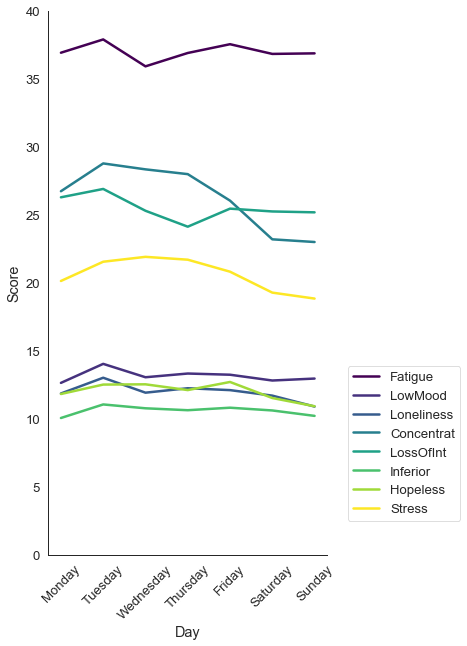

In [38]:
ax = dailyMeans.iloc[:,:-3].plot(kind="line", legend=True, cmap='viridis', figsize = (5,10))
ax.legend(loc=4, bbox_to_anchor=(1.5, .05))
ax.set_ylim([0,40])
ax.set_ylabel("Score")
plt.xticks(rotation=45)

sns.despine()
plt.savefig('../figures/ESM_quest-var-line.png')

How large was the variation over time between the days with the highest and lowest scores, respectively?

In [39]:
for column in dailyMeans.columns:
    print(column, dailyMeans.loc[:,column].max() - dailyMeans.loc[:,column].min())

Fatigue 1.9798305001594443
LowMood 1.3992155729086626
Loneliness 2.1203201313032327
Concentrat 5.782373656492261
LossOfInt 2.7768333237773035
Inferior 0.9974514793851377
Hopeless 1.784970276409366
Stress 3.0708119043687567
PSMU 6.129405816248308
News 3.0119218678602273
ASMU 5.417096095972298
